In [ ]:
!unzip "/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/KneeXray.zip"

In [ ]:
#changing filename to paths
import os
import pandas as pd
import numpy as np
import PIL
import cv2

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_data = pd.read_csv("/content/KneeXray/Train.csv")
test_data = pd.read_csv("/content/KneeXray/Test.csv")

paths = [os.path.join("/content/KneeXray/train", x) for x in train_data['filename']]
test_paths = [os.path.join("/content/KneeXray/Test.csv", x) for x in test_data['filename']]

In [ ]:
train_data['image_path'] = paths
test_data['image_path'] = test_paths

train_data.drop(['filename'], axis = 1, inplace=True)
test_data.drop(['filename'], axis = 1, inplace=True)

In [ ]:
train_data['label'].value_counts()

0    3085
2    2062
1    1416
3    1029
4     236
Name: label, dtype: int64

In [ ]:
def display_img(KL_Grade:int):
  temp = train_data[train_data['label'] == KL_Grade]
  img = PIL.Image.open(temp.sample()['image_path'].values[0]).convert('RGB')
  return img

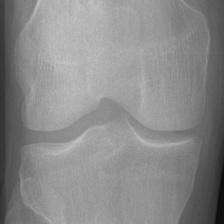

In [ ]:
display_img(0)

In [ ]:
def preprocess_image(img_array):
  gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
  # smooth = cv2.medianBlur(gray, 3)
  smooth = cv2.GaussianBlur(gray,(3,3),0)
  eql = cv2.equalizeHist(smooth)
  return cv2.cvtColor(eql, cv2.COLOR_GRAY2RGB)

In [ ]:
def display_sample(use_preprocess = False):
  imgs = [display_img(x) for x in range(5)]
  min_shape = sorted( [(np.sum(i.size), i.size) for i in imgs])[0][1]
  if use_preprocess:
    imgs_comb = np.hstack(preprocess_image(np.asarray(i.resize(min_shape)))for i in imgs)
  else:
    imgs_comb = np.hstack((np.asarray( i.resize(min_shape)) for i in imgs))
  print("Order of KL-Grade --> 0, 1, 2, 3, 4")
  return PIL.Image.fromarray(imgs_comb)

Order of KL-Grade --> 0, 1, 2, 3, 4


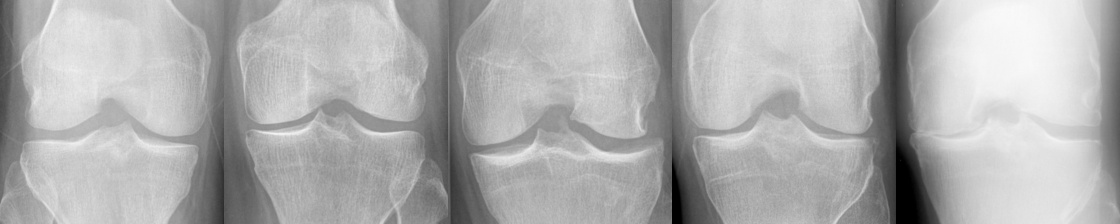

In [ ]:
display_sample(use_preprocess=False)

Order of KL-Grade --> 0, 1, 2, 3, 4


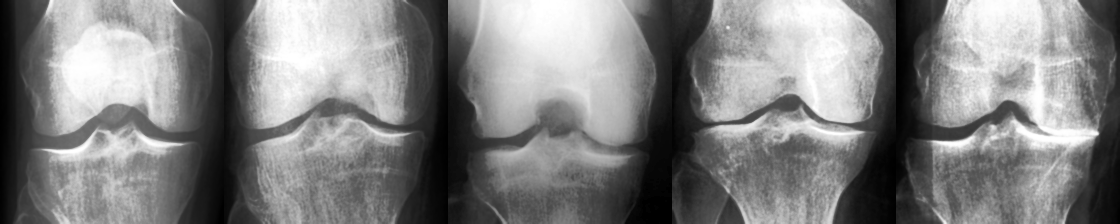

In [ ]:
display_sample(use_preprocess=True)

In [ ]:
dfx = train_data.copy()

from sklearn import model_selection
dfx["kfold"] = -1

dfx = dfx.sample(frac=1).reset_index(drop=True)

kf = model_selection.StratifiedKFold(n_splits=5)

for fold, (trn_, val_) in enumerate(kf.split(X=dfx, y=dfx.label.values)):
    print(len(trn_), len(val_))
    dfx.loc[val_, 'kfold'] = fold

dfx.to_csv("/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/train_set_folds.csv", index = False)

6262 1566
6262 1566
6262 1566
6263 1565
6263 1565


#Training Module

In [ ]:
!pip install pytorch-lightning
!pip install albumentations==0.4.6
!pip install git+https://github.com/rwightman/pytorch-image-models.git

In [ ]:
import os
import albumentations
from albumentations.pytorch import ToTensorV2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import models
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.transforms import transforms

from sklearn import metrics, model_selection, preprocessing

import PIL
from PIL import Image
from PIL import ImageFilter

import cv2

import timm

import pytorch_lightning as pl

from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor, BackboneFinetuning
# from pytorch_lightning.loggers import NeptuneLogger


import torchmetrics as tm

import warnings
warnings.filterwarnings('ignore')

from google.colab.patches import cv2_imshow

In [ ]:
timm.list_models()

In [ ]:
class CONFIG():

  train_images = "/content/KneeXray/train"
  test_images = "/content/KneeXray/test"
  drive_path = "/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis"

  trainset = "/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/train_set_folds.csv"

  model_folder = "/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models"

  model_name = "resnext50_32x4d"
  pretrained = True

  num_classes = 5

  virtual_batch_size = 32
  batch_size_train = 32
  batch_size_val = 16
  use_preprocess = True

  max_epochs = 30
  lr = 1e-4
  weight_decay = 1e-3

  nfolds = 5


cfg = CONFIG()

In [ ]:
train_data = pd.read_csv(cfg.trainset)
dfx = train_data.copy()

In [ ]:
def display_img(KL_Grade:int):
  temp = train_data[train_data['label'] == KL_Grade]
  img = PIL.Image.open(temp.sample()['image_path'].values[0]).convert('RGB')
  return img

def preprocess_image(img_array):
  gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
  # smooth = cv2.medianBlur(gray, 3)
  smooth = cv2.GaussianBlur(gray,(3,3),0)
  eql = cv2.equalizeHist(smooth)
  return cv2.cvtColor(eql, cv2.COLOR_GRAY2RGB)

def display_sample(use_preprocess = False):
  imgs = [display_img(x) for x in range(5)]
  min_shape = sorted( [(np.sum(i.size), i.size) for i in imgs])[0][1]
  if use_preprocess:
    imgs_comb = np.hstack(preprocess_image(np.asarray(i.resize(min_shape)))for i in imgs)
  else:
    imgs_comb = np.hstack((np.asarray( i.resize(min_shape)) for i in imgs))
  print("Order of KL-Grade --> 0, 1, 2, 3, 4")
  return PIL.Image.fromarray(imgs_comb)

def scaling(X, high, low):
  X_std = (X - X.min()) / (X.max() - X.min())
  X_scaled = X_std * (high - low) + low
  return X_scaled

In [ ]:
class Data(Dataset):
    def __init__(self, dataframe, transform, one_hot = False, use_preprocess = True):
        super().__init__()
        self.dataframe = dataframe
        self.transform = transform
        self.one_hot = one_hot
        self.use_preprocess = use_preprocess
    
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, item):
        img_path = self.dataframe.iloc[item]['image_path']
        target = self.dataframe.iloc[item]['label']
        image = Image.open(img_path).convert('RGB')
        image = np.asarray(image)
        if self.use_preprocess :
          image = preprocess_image(image)
        if self.transform is not None:
            image = self.transform(image = image)['image']
        if self.one_hot:
            return image, F.one_hot(torch.tensor(target), num_classes=cfg.num_classes)
        else:
            return image, torch.tensor(target)

class TestData(Dataset):
    def __init__(self, dataframe, transform, use_preprocess = True):
        super().__init__()
        self.dataframe = dataframe
        self.transform = transform
        self.use_preprocess = use_preprocess
    
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, item):
      img_id = self.dataframe.iloc[item]['filename']
      img_path = os.path.join(cfg.test_images,img_id)
      image = Image.open(img_path).convert('RGB')
      image = np.asarray(image)
      if self.use_preprocess:
        image = preprocess_image(image)
      if self.transform is not None:
        image = self.transform(image = image)['image']

      return image

In [ ]:
train_aug = albumentations.Compose([
            albumentations.Rotate(limit = 15, p = 0.3),
            albumentations.OneOf([
                albumentations.Cutout(num_holes=8, max_h_size=2, max_w_size=2, fill_value=0, always_apply=False),
                albumentations.ElasticTransform()
            ], p = 0.5),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ), ToTensorV2(),
            ])
  
        
val_aug = albumentations.Compose([
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ), ToTensorV2(),
])

In [ ]:
class CNN_Classifier(nn.Module):
    def __init__(self, model_name, pretrained = True):
        super().__init__()
        self.cnn = timm.create_model(model_name = model_name, pretrained=pretrained)
        self.classifier = nn.Sequential(nn.Dropout(0.1),
                                    nn.LeakyReLU(),
                                    nn.Linear(1000,cfg.num_classes))
        
    def forward(self, x):
        output = self.cnn(x)
        output = self.classifier(output)
        return output

In [ ]:
class DataModule(pl.LightningDataModule):

    def __init__(self, fold: int, train_batch_size: int, valid_batch_size: int, one_hot: bool = False):
        super().__init__()
        self.fold = fold
        self.train_batch_size = train_batch_size
        self.valid_batch_size = valid_batch_size
        self.one_hot = one_hot
        self.train_transform = train_aug
        self.valid_transform = val_aug

    def setup(self, stage: str = None):
        df_train = dfx[dfx.kfold != self.fold].reset_index(drop=True)
        df_valid = dfx[dfx.kfold == self.fold].reset_index(drop=True)

        df_train = df_train.reset_index(drop=True)
        df_valid = df_valid.reset_index(drop=True)

        self.train_dataset = Data(
            dataframe = df_train,
            transform = self.train_transform,
            one_hot = self.one_hot,
            use_preprocess = cfg.use_preprocess
        )

        self.valid_dataset = Data(
            dataframe = df_valid,
            transform = self.valid_transform,
            one_hot = self.one_hot,
            use_preprocess = cfg.use_preprocess
        )     

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size = self.train_batch_size, shuffle = True, pin_memory = True, num_workers = 4, drop_last=True)
      
    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size = self.valid_batch_size, shuffle = False, pin_memory = True, num_workers = 4, drop_last=True)

In [ ]:
class CNNModule(pl.LightningModule):
    def __init__(self, model_name, learning_rate = 1e-4, use_scheduler = True, pretrained = True):
        super().__init__()

        self.net = CNN_Classifier(model_name, pretrained = pretrained)

        self.loss_function = nn.BCEWithLogitsLoss()
        self.learning_rate = learning_rate
        self.use_scheduler = use_scheduler
        self.save_hyperparameters()

        self.train_metric = tm.Accuracy()
        self.valid_metric = tm.Accuracy()

    def forward(self, x):
        output = self.net(x)
        return output

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=cfg.weight_decay)
        lr_scheduler = {
        "scheduler":torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=5, T_mult=1, eta_min=1e-6, last_epoch=-1, verbose = True
            ),
        "name":"CosineAnnealingWarmRestarts",
        }

        # lr_scheduler = {
        # "scheduler":torch.optim.lr_scheduler.OneCycleLR(optimizer, 1e-4, total_steps=None, epochs=10, steps_per_epoch=len(self.train_dataloader()), pct_start=0.3, 
        #                                                 anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=25.0, 
        #                                                 final_div_factor=10000.0, three_phase=False, last_epoch=-1, verbose=True),
        # "name":"OneCycleLR",
        # "interval":"step"
        # }

        # lr_scheduler = {
        # "scheduler":torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, 
        #                                                         threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08, verbose = True),
        # "name":"ReduceLROnPlateau",
        # "monitor":"Validation_loss_epoch",
        # "interval":"epoch"
        # }

        # lr_scheduler = {
        # "scheduler":torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=  [3,7], gamma=0.1, last_epoch=-1, verbose=True),
        # "name":"MultiStepLR",
        # }

        if self.use_scheduler:
              return [optimizer], [lr_scheduler]
        else:
              return optimizer

    def training_step(self, batch, batch_idx):
        image, targets = batch
        y_pred = self.forward(image)
        loss = self.loss_function(y_pred, targets.type_as(y_pred))
        train_acc_batch = self.train_metric(torch.sigmoid(y_pred), targets)
        self.log('train_acc_batch', train_acc_batch, prog_bar = True)
        self.log('train_loss_batch', loss)
        return {
            'loss': loss,
            'train_acc_batch': train_acc_batch,
        }

    def training_epoch_end(self, outputs):
        current_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
        current_train_acc = self.train_metric.compute()
        self.log('Training_loss_epoch', current_train_loss)
        self.log('Training_ACC_epoch', current_train_acc)

    def validation_step(self, batch, batch_idx):
        image, targets = batch
        y_pred = self.forward(image)
        loss = self.loss_function(y_pred, targets.type_as(y_pred))
        val_acc_batch = self.valid_metric(torch.sigmoid(y_pred), targets)
        self.log('val_acc_batch', val_acc_batch)
        self.log('val_loss_batch', loss)
        return {
          'val_loss': loss,
          'val_acc_batch': val_acc_batch
          }

    def validation_epoch_end(self, outputs):
        current_val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        current_val_acc = self.valid_metric.compute()
        print(f"Epoch {self.current_epoch}: Loss: {current_val_loss:4f}: Acc:{current_val_acc:4f}")
        self.log("Validation_loss_epoch", current_val_loss)
        self.log('Validation_ACC_epoch', current_val_acc)

In [ ]:
def run(fold):

    print(f"Running Fold-{fold}")


    check_path = f"{cfg.model_folder}/{cfg.model_name}/{fold}"

    checkpointer = ModelCheckpoint(
    monitor = 'Validation_loss_epoch',
    dirpath = check_path,
    filename =  f"{cfg.model_name}" + "-{epoch:02d}-{Validation_loss_epoch:2f}",
    mode = 'min',
    save_top_k = 1,
    save_weights_only = True,
    verbose = True
  )

    early_stopping = EarlyStopping(
    monitor = 'Validation_loss_epoch',
    patience = 5,
    mode = 'min'
    )

    learning_rate_monitor = LearningRateMonitor(logging_interval = 'epoch')

    callbacks = [checkpointer, 
                 early_stopping, 
                 learning_rate_monitor,
                 ]
    
    
    model = CNNModule(model_name = cfg.model_name, learning_rate=cfg.lr, pretrained = cfg.pretrained)
    
    dm = DataModule(fold = fold, train_batch_size = cfg.batch_size_train, valid_batch_size=cfg.batch_size_val, one_hot = True)
    
    trainer = pl.Trainer(
    callbacks = callbacks,
    max_epochs = cfg.max_epochs,
    progress_bar_refresh_rate = 20,
    accumulate_grad_batches=int(cfg.virtual_batch_size/cfg.batch_size_train),
    gpus = 1,
    precision = 16,
    move_metrics_to_cpu = True 
    )

    trainer.fit(model, dm)

In [ ]:
run(2)

Running Fold-2


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnext50_32x4d_ra-d733960d.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d_ra-d733960d.pth
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch     0: adjusting learning rate of group 0 to 1.0000e-04.



  | Name          | Type              | Params
----------------------------------------------------
0 | net           | CNN_Classifier    | 25.0 M
1 | loss_function | BCEWithLogitsLoss | 0     
2 | train_metric  | Accuracy          | 0     
3 | valid_metric  | Accuracy          | 0     
----------------------------------------------------
25.0 M    Trainable params
0         Non-trainable params
25.0 M    Total params
100.136   Total estimated model params size (MB)


Epoch 0: Loss: 0.683486: Acc:0.462500


Epoch 0, global step 194: Validation_loss_epoch reached 0.31993 (best 0.31993), saving model to "/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/resnext50_32x4d/2/resnext50_32x4d-epoch=00-Validation_loss_epoch=0.319927.ckpt" as top 1


Epoch 0: Loss: 0.319927: Acc:0.846338
Epoch     1: adjusting learning rate of group 0 to 9.0546e-05.


Epoch 1, global step 389: Validation_loss_epoch reached 0.30018 (best 0.30018), saving model to "/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/resnext50_32x4d/2/resnext50_32x4d-epoch=01-Validation_loss_epoch=0.300180.ckpt" as top 1


Epoch 1: Loss: 0.300180: Acc:0.855230
Epoch     2: adjusting learning rate of group 0 to 6.5796e-05.


Epoch 2, global step 584: Validation_loss_epoch reached 0.28546 (best 0.28546), saving model to "/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/resnext50_32x4d/2/resnext50_32x4d-epoch=02-Validation_loss_epoch=0.285458.ckpt" as top 1


Epoch 2: Loss: 0.285458: Acc:0.860879
Epoch     3: adjusting learning rate of group 0 to 3.5204e-05.


Epoch 3, global step 779: Validation_loss_epoch was not in top 1


Epoch 3: Loss: 0.289784: Acc:0.864231
Epoch     4: adjusting learning rate of group 0 to 1.0454e-05.


Epoch 4, global step 974: Validation_loss_epoch was not in top 1


Epoch 4: Loss: 0.299215: Acc:0.865734
Epoch     5: adjusting learning rate of group 0 to 1.0000e-04.


Epoch 5, global step 1169: Validation_loss_epoch was not in top 1


Epoch 5: Loss: 0.321812: Acc:0.865518
Epoch     6: adjusting learning rate of group 0 to 9.0546e-05.


Epoch 6, global step 1364: Validation_loss_epoch was not in top 1


Epoch 6: Loss: 0.347657: Acc:0.864170
Epoch     7: adjusting learning rate of group 0 to 6.5796e-05.


Epoch 7, global step 1559: Validation_loss_epoch was not in top 1


Epoch 7: Loss: 0.321634: Acc:0.865103
Epoch     8: adjusting learning rate of group 0 to 3.5204e-05.



In [ ]:
run(3)

Running Fold-3


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | net           | CNN_Classifier    | 25.0 M
1 | loss_function | BCEWithLogitsLoss | 0     
2 | train_metric  | Accuracy          | 0     
3 | valid_metric  | Accuracy          | 0     
----------------------------------------------------
25.0 M    Trainable params
0         Non-trainable params
25.0 M    Total params
100.136   Total estimated model params size (MB)


Epoch     0: adjusting learning rate of group 0 to 1.0000e-04.


Epoch 0: Loss: 0.631488: Acc:0.706250


Epoch 0, global step 194: Validation_loss_epoch reached 0.32225 (best 0.32225), saving model to "/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/resnext50_32x4d/3/resnext50_32x4d-epoch=00-Validation_loss_epoch=0.322249.ckpt" as top 1


Epoch 0: Loss: 0.322249: Acc:0.849369
Epoch     1: adjusting learning rate of group 0 to 9.0546e-05.


Epoch 1, global step 389: Validation_loss_epoch reached 0.29460 (best 0.29460), saving model to "/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/resnext50_32x4d/3/resnext50_32x4d-epoch=01-Validation_loss_epoch=0.294596.ckpt" as top 1


Epoch 1: Loss: 0.294596: Acc:0.858163
Epoch     2: adjusting learning rate of group 0 to 6.5796e-05.


Epoch 2, global step 584: Validation_loss_epoch reached 0.28426 (best 0.28426), saving model to "/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/resnext50_32x4d/3/resnext50_32x4d-epoch=02-Validation_loss_epoch=0.284261.ckpt" as top 1


Epoch 2: Loss: 0.284261: Acc:0.861988
Epoch     3: adjusting learning rate of group 0 to 3.5204e-05.


Epoch 3, global step 779: Validation_loss_epoch was not in top 1


Epoch 3: Loss: 0.315996: Acc:0.863718
Epoch     4: adjusting learning rate of group 0 to 1.0454e-05.


Epoch 4, global step 974: Validation_loss_epoch was not in top 1


Epoch 4: Loss: 0.304743: Acc:0.866453
Epoch     5: adjusting learning rate of group 0 to 1.0000e-04.


Epoch 5, global step 1169: Validation_loss_epoch was not in top 1


Epoch 5: Loss: 0.358487: Acc:0.864876
Epoch     6: adjusting learning rate of group 0 to 9.0546e-05.


Epoch 6, global step 1364: Validation_loss_epoch was not in top 1


Epoch 6: Loss: 0.313596: Acc:0.867015
Epoch     7: adjusting learning rate of group 0 to 6.5796e-05.


Epoch 7, global step 1559: Validation_loss_epoch was not in top 1


Epoch 7: Loss: 0.339905: Acc:0.868091
Epoch     8: adjusting learning rate of group 0 to 3.5204e-05.



In [ ]:
run(4)

Running Fold-4


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | net           | CNN_Classifier    | 25.0 M
1 | loss_function | BCEWithLogitsLoss | 0     
2 | train_metric  | Accuracy          | 0     
3 | valid_metric  | Accuracy          | 0     
----------------------------------------------------
25.0 M    Trainable params
0         Non-trainable params
25.0 M    Total params
100.136   Total estimated model params size (MB)


Epoch     0: adjusting learning rate of group 0 to 1.0000e-04.


Epoch 0: Loss: 0.748211: Acc:0.481250


Epoch 0, global step 194: Validation_loss_epoch reached 0.32059 (best 0.32059), saving model to "/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/resnext50_32x4d/4/resnext50_32x4d-epoch=00-Validation_loss_epoch=0.320590.ckpt" as top 1


Epoch 0: Loss: 0.320590: Acc:0.845328
Epoch     1: adjusting learning rate of group 0 to 9.0546e-05.


Epoch 1, global step 389: Validation_loss_epoch reached 0.31115 (best 0.31115), saving model to "/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/resnext50_32x4d/4/resnext50_32x4d-epoch=01-Validation_loss_epoch=0.311152.ckpt" as top 1


Epoch 1: Loss: 0.311152: Acc:0.852742
Epoch     2: adjusting learning rate of group 0 to 6.5796e-05.


Epoch 2, global step 584: Validation_loss_epoch reached 0.28267 (best 0.28267), saving model to "/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/resnext50_32x4d/4/resnext50_32x4d-epoch=02-Validation_loss_epoch=0.282668.ckpt" as top 1


Epoch 2: Loss: 0.282668: Acc:0.858831
Epoch     3: adjusting learning rate of group 0 to 3.5204e-05.


Epoch 3, global step 779: Validation_loss_epoch was not in top 1


Epoch 3: Loss: 0.310424: Acc:0.860545
Epoch     4: adjusting learning rate of group 0 to 1.0454e-05.


Epoch 4, global step 974: Validation_loss_epoch was not in top 1


Epoch 4: Loss: 0.312716: Acc:0.864066
Epoch     5: adjusting learning rate of group 0 to 1.0000e-04.


Epoch 5, global step 1169: Validation_loss_epoch was not in top 1


Epoch 5: Loss: 0.334527: Acc:0.863848
Epoch     6: adjusting learning rate of group 0 to 9.0546e-05.


Epoch 6, global step 1364: Validation_loss_epoch was not in top 1


Epoch 6: Loss: 0.331030: Acc:0.863656
Epoch     7: adjusting learning rate of group 0 to 6.5796e-05.


Epoch 7, global step 1559: Validation_loss_epoch was not in top 1


Epoch 7: Loss: 0.379264: Acc:0.864428
Epoch     8: adjusting learning rate of group 0 to 3.5204e-05.



# Inference

In [ ]:
class CONFIG_INFERENCE():
  test_images = "/content/KneeXray/test"
  testset = "/content/KneeXray/sample_submission.csv"

  model_paths = [
                 '/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/resnext50_32x4d/0/resnext50_32x4d-epoch=02-Validation_loss_epoch=0.283553.ckpt',
                 '/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/resnext50_32x4d/1/resnext50_32x4d-epoch=03-Validation_loss_epoch=0.280259.ckpt',
                 '/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/resnext50_32x4d/2/resnext50_32x4d-epoch=02-Validation_loss_epoch=0.285458.ckpt',
                 '/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/resnext50_32x4d/3/resnext50_32x4d-epoch=02-Validation_loss_epoch=0.284261.ckpt',
                 '/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/resnext50_32x4d/4/resnext50_32x4d-epoch=02-Validation_loss_epoch=0.282668.ckpt'
                 ]


  batch_size = 32

  device = ('cuda' if torch.cuda.is_available() else 'cpu')


cfg_inference = CONFIG_INFERENCE()

In [ ]:
test_aug = albumentations.Compose([
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ), ToTensorV2(),
])

In [ ]:
dfx_test = pd.read_csv(cfg_inference.testset)
test_dataset = TestData(dataframe=dfx_test, transform=test_aug)
test_dataloader = DataLoader(test_dataset, batch_size=cfg_inference.batch_size, shuffle = False)

In [ ]:
def load_model(path):
  w = torch.load(path, map_location=cfg_inference.device)
  m = CNNModule(model_name = cfg.model_name, pretrained = False)
  m.load_state_dict(w['state_dict'])
  return m.net

In [ ]:
from tqdm import tqdm
final_preds = None
for path in cfg_inference.model_paths:
  model = load_model(path)
  model.to(cfg_inference.device)
  temp_preds = None
  model.eval()
  for batch in tqdm(test_dataloader):
    images = batch.to(cfg_inference.device)
    preds = torch.sigmoid(model(images)).cpu().detach().numpy()
    if temp_preds is None:
        temp_preds = preds
    else:
        temp_preds = np.vstack((temp_preds, preds))
  
  if final_preds is None:
      final_preds = temp_preds
  else:
      final_preds += temp_preds
final_preds /= len(cfg_inference.model_paths)

100%|██████████| 62/62 [00:12<00:00,  5.03it/s]


In [ ]:
sub = pd.read_csv("/content/KneeXray/sample_submission.csv")
sub['label'] = final_preds.argmax(axis = 1)

In [ ]:
sub['label'].value_counts()

0    954
2    542
3    244
1    158
4     60
Name: label, dtype: int64

In [ ]:
sub.to_csv(f"{cfg.model_name}_0_1_2_3_4.csv",index = False)

# Interpretation

In [ ]:
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random

In [ ]:
class CONFIG_INTER():

  weights_dict = {
      "resnext50_32x4d": "/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/resnext50_32x4d/0/resnext50_32x4d-epoch=02-Validation_loss_epoch=0.283553.ckpt",
      "densenet121": "/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/densenet121/0/densenet121-epoch=05-Validation_loss_epoch=0.300670.ckpt",
      "densenet161": "/content/drive/MyDrive/Projects/DPHI-Knee_Osteoarthritis/models/densenet161/0/densenet161-epoch=02-Validation_loss_epoch=0.278351.ckpt"
  }

cfg_inter = CONFIG_INTER()

In [ ]:
def preprocess_salient(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

def deprocess_salient(image):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.ToPILImage(),
    ])
    return transform(image)

def random_image():
  idx = random.randrange(len(dfx))
  row = dfx.iloc[idx]
  img = np.asarray(Image.open(row['image_path']).convert('RGB'))
  img = preprocess_image(img)
  return Image.fromarray(img), row['label']

In [ ]:
def create_saliency_map(model_name, img_tensor):

  path = cfg_inter.weights_dict[model_name]
  model = CNNModule(model_name, pretrained = False)
  weights = torch.load(path, map_location=torch.device('cpu'))
  model.load_state_dict(weights['state_dict'])
  model = model.net

  model.eval()

  img_tensor.requires_grad_()

  scores = model(img_tensor)

  score_max_index = scores.argmax()
  score_max = scores[0,score_max_index]
  score_max.backward()

  saliency, _ = torch.max(img_tensor.grad.data.abs(),dim=1)

  del model

  return saliency

In [ ]:
def superimpose(saliency, img):
  img_array = np.asarray(img)
  img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
  img_array = np.uint8(scaling(img_array, 255, 0))
  s = saliency[0]
  s = np.uint8(scaling(s, 255, 0))
  superimposed = cv2.addWeighted(s, 0.8, img_array, 0.2, 0)
  return superimposed

In [ ]:
def saliency_map(KL_Grade:int, model_name):
  img = display_img(KL_Grade=KL_Grade)
  img = Image.fromarray(preprocess_image(np.asarray(img)))
  saliency = create_saliency_map(model_name, preprocess_salient(img))
  superimposed_image = superimpose(saliency, img)
  print(f"For KL-Grade {KL_Grade} osteoarthritis")
  fig = plt.figure(figsize=(12, 12))
  ax = plt.subplot(1, 2, 1)
  ax.imshow(np.asarray(img))
  plt.axis('off')
  ax = plt.subplot(1,2,2)
  ax.imshow(superimposed_image, cmap = 'hot')
  plt.axis('off')
  plt.show()

For KL-Grade 0 osteoarthritis


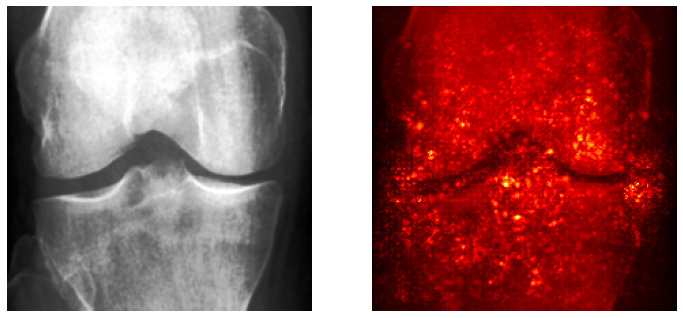

In [ ]:
saliency_map(0, 'resnext50_32x4d')

For KL-Grade 1 osteoarthritis


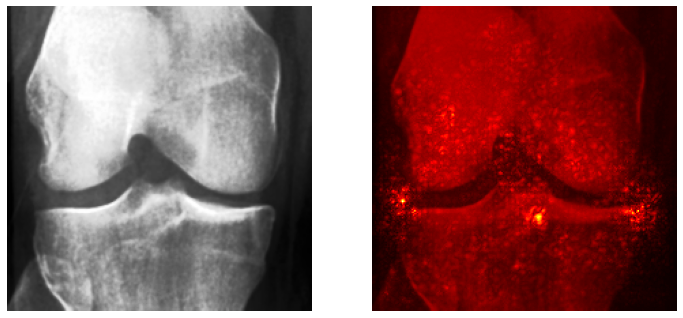

In [ ]:
saliency_map(1, 'resnext50_32x4d')

For KL-Grade 2 osteoarthritis


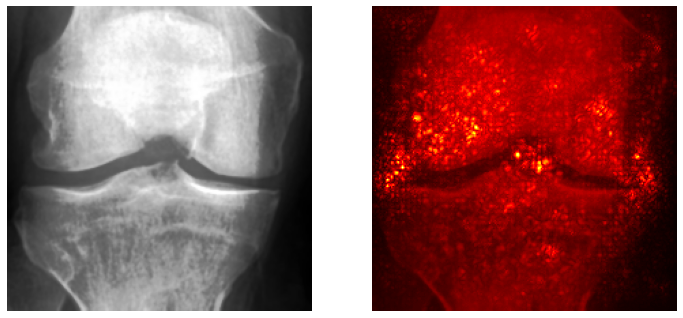

In [ ]:
saliency_map(2, 'resnext50_32x4d')

For KL-Grade 3 osteoarthritis


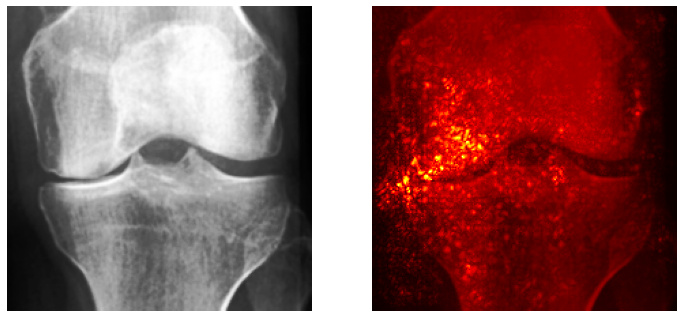

In [ ]:
saliency_map(3, 'resnext50_32x4d')

For KL-Grade 4 osteoarthritis


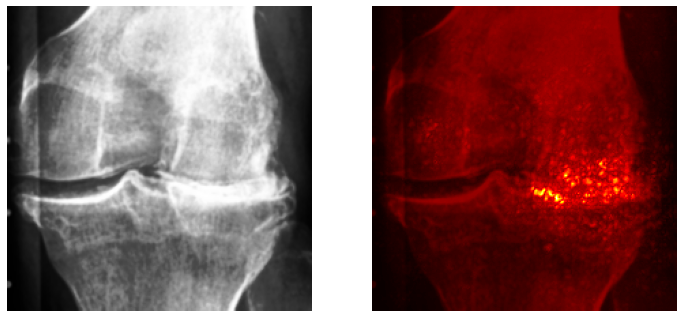

In [ ]:
saliency_map(4, 'resnext50_32x4d')